<h3>Bag of N Grams</h3>
<p> <li> Meaning of a sentence is determined by order of words </li>
<li> Bi-gram: we take two words together in a pair
<li> We can combine bag of words and bi-grams for better results
</p>

In [1]:
from sklearn.feature_extraction.text import CountVectorizer

v = CountVectorizer(ngram_range=(1,3))
v.fit(["Thor Hathodawala is looking for a job"])
v.vocabulary_

{'thor': 12,
 'hathodawala': 2,
 'is': 5,
 'looking': 9,
 'for': 0,
 'job': 8,
 'thor hathodawala': 13,
 'hathodawala is': 3,
 'is looking': 6,
 'looking for': 10,
 'for job': 1,
 'thor hathodawala is': 14,
 'hathodawala is looking': 4,
 'is looking for': 7,
 'looking for job': 11}

In [2]:
corpus =[
    "Thor ate pizza",
    "Loki is tall",
    "Loki is eating pizza"
]

In [3]:
import spacy

# load english language model and create nlp object from it
nlp = spacy.load("en_core_web_sm")

def preprocess(text):
    doc = nlp(text)

    filtered_tokens = []

    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)
    
    return " ".join(filtered_tokens)


In [4]:
preprocess("Thor ate pizza")

'thor eat pizza'

In [5]:
corpus_processed = [preprocess(text) for text in corpus]
corpus_processed

['thor eat pizza', 'Loki tall', 'Loki eat pizza']

In [6]:
v = CountVectorizer(ngram_range=(1,2))
v.fit(corpus_processed)
v.vocabulary_

{'thor': 7,
 'eat': 0,
 'pizza': 5,
 'thor eat': 8,
 'eat pizza': 1,
 'loki': 2,
 'tall': 6,
 'loki tall': 4,
 'loki eat': 3}

In [7]:
# convert text into vector

v.transform(["Thor eat pizza"]).toarray()

array([[1, 1, 0, 0, 0, 1, 0, 1, 1]], dtype=int64)

In [10]:
import pandas as pd

df = pd.read_json("news_dataset.json")

df.head(5)

,text,category
0,Watching Schrödinger's Cat Die University of C...,SCIENCE
1,WATCH: Freaky Vortex Opens Up In Flooded Lake,SCIENCE
2,Entrepreneurs Today Don't Need a Big Budget to...,BUSINESS
3,These Roads Could Recharge Your Electric Car A...,BUSINESS
4,Civilian 'Guard' Fires Gun While 'Protecting' ...,CRIME


In [11]:
df.shape

(12695, 2)

In [12]:
df.category.value_counts()

category
BUSINESS    4254
SPORTS      4167
CRIME       2893
SCIENCE     1381
Name: count, dtype: int64

In [19]:
# handle class imbalance

min_samples = 1381

df_business = df[df.category=="BUSINESS"].sample(min_samples, random_state=2024)
df_sports = df[df.category=="SPORTS"].sample(min_samples, random_state=2024)
df_crime = df[df.category=="CRIME"].sample(min_samples, random_state=2024)
df_science = df[df.category=="SCIENCE"].sample(min_samples, random_state=2024)

In [22]:
df_balanced = pd.concat([df_business, df_sports, df_crime, df_science])
df_balanced.category.value_counts()

category
BUSINESS    1381
SPORTS      1381
CRIME       1381
SCIENCE     1381
Name: count, dtype: int64

In [26]:
target = {"BUSINESS" : 0, "SPORTS" : 1, "CRIME" : 2, "SCIENCE" : 3}

df_balanced['category_num'] = df_balanced.category.map(target)

In [27]:
df_balanced

,text,category,category_num
2487,Amazon To Challenge Alibaba In Global Delivery...,BUSINESS,0
12534,"A Tale of Two Investors Like many investors, P...",BUSINESS,0
10014,"Quit Working So Hard At the end of the day, ho...",BUSINESS,0
4605,The Rating Game It's hard to find a restaurant...,BUSINESS,0
6833,Has Instant Messaging Become More Annoying Tha...,BUSINESS,0
...,...,...,...
1753,How Scientists Know Climate Change Is Happenin...,SCIENCE,3
3991,These Personality Traits Could Put You At Risk...,SCIENCE,3
4916,Who Was The Last Person On Earth Born In The 1...,SCIENCE,3
5826,Are Nasty Comments Like These Keeping Women Ou...,SCIENCE,3


In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_balanced.text,
    df_balanced.category_num,
    test_size = 0.2,
    random_state=2024,
    stratify=df_balanced.category_num # so that equal samples from each class are taken
)

In [32]:
print(X_train.shape)
X_train.head()

(4419,)


12136    How Early-Life Stress Could Increase Risk Of A...
711      NFL Star Takes Away His Sons' Participation Tr...
5356     What Would Happen If You Fell Into A Black Hole? 
191      The Carnivore Way: All Who Wander Are Not Lost...
6943     The Total Solar Eclipse Is Finally Here And Th...
Name: text, dtype: object

In [33]:
y_test.value_counts()

category_num
0    277
1    276
3    276
2    276
Name: count, dtype: int64

In [35]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

clf = Pipeline([
    ('vectorizer_bow', CountVectorizer()),
    ('Multi NB', MultinomialNB())
])

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.87      0.81       277
           1       0.91      0.84      0.87       276
           2       0.89      0.91      0.90       276
           3       0.89      0.79      0.84       276

    accuracy                           0.85      1105
   macro avg       0.86      0.85      0.85      1105
weighted avg       0.86      0.85      0.85      1105



In [36]:
clf = Pipeline([
    ('vectorizer_bi_gram', CountVectorizer(ngram_range=(1,2))),
    ('Multi NB', MultinomialNB())
])

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.92      0.80       277
           1       0.95      0.82      0.88       276
           2       0.90      0.90      0.90       276
           3       0.93      0.78      0.85       276

    accuracy                           0.85      1105
   macro avg       0.87      0.85      0.85      1105
weighted avg       0.87      0.85      0.85      1105



In [37]:
# now preprocess the text and train again

df_balanced["preprocessed_text"] = df_balanced.text.apply(preprocess)

In [38]:
df_balanced.head()

,text,category,category_num,preprocessed_text
2487,Amazon To Challenge Alibaba In Global Delivery...,BUSINESS,0,Amazon challenge Alibaba Global Delivery Marke...
12534,"A Tale of Two Investors Like many investors, P...",BUSINESS,0,Tale Investors like investor Paul Mary trust W...
10014,"Quit Working So Hard At the end of the day, ho...",BUSINESS,0,Quit Working hard end day time purely truly pr...
4605,The Rating Game It's hard to find a restaurant...,BUSINESS,0,Rating Game hard find restaurant place little ...
6833,Has Instant Messaging Become More Annoying Tha...,BUSINESS,0,instant messaging annoying Email 5 step produc...


In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_balanced.preprocessed_text,
    df_balanced.category_num,
    test_size = 0.2,
    random_state=2024,
    stratify=df_balanced.category_num # so that equal samples from each class are taken
)

In [40]:
clf = Pipeline([
    ('vectorizer_bi_gram', CountVectorizer(ngram_range=(1,2))),
    ('Multi NB', MultinomialNB())
])

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       277
           1       0.92      0.87      0.89       276
           2       0.85      0.93      0.89       276
           3       0.94      0.82      0.88       276

    accuracy                           0.88      1105
   macro avg       0.88      0.88      0.88      1105
weighted avg       0.88      0.88      0.88      1105



<h5> Plot Confusion matrix </h5>

In [42]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm

array([[245,  12,  15,   5],
       [ 11, 240,  19,   6],
       [ 11,   3, 258,   4],
       [ 30,   7,  12, 227]], dtype=int64)

Text(95.72222222222221, 0.5, 'Truth')

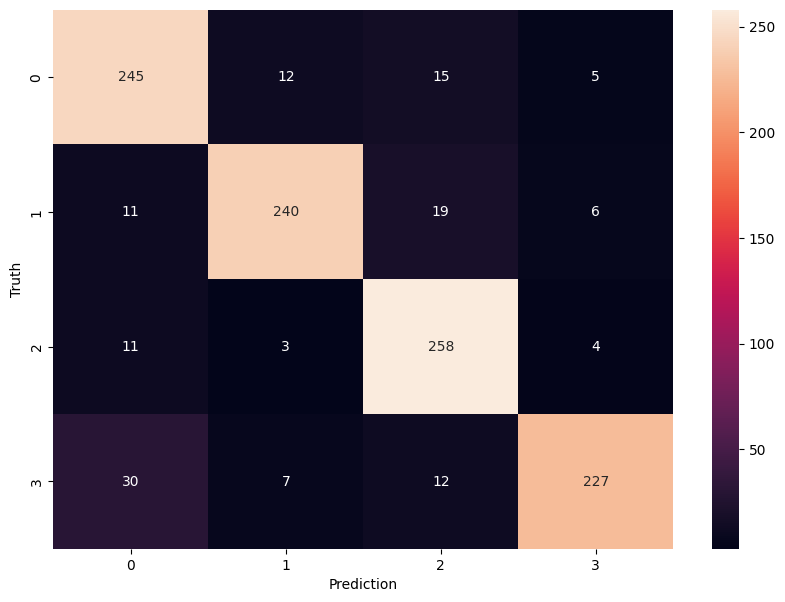

In [43]:
from matplotlib import pyplot as plt
import seaborn as sn

plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')